In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import sentencepiece as spm
import matplotlib.pyplot as plt
import os
import textwrap
import torchvision.models as models

In [2]:
# Load tokenizer
sp = spm.SentencePieceProcessor()
sp.load('/kaggle/input/flickr8k-trained-model/spm.model')


True

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class ImgToCaptionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, max_seq_len=50):
        super().__init__()
        
        # Store params
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.max_seq_len = max_seq_len
        
        # CNN ENCODER (pretrained ResNet-50)
        # architecture: conv1, layer1, layer2, layer3, layer3 => 
        # 64 -> 256 -> 512 -> 1024 -> 2048 output
        resnet = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])  # (B, 2048, 8, 8)

        # Freeze all
        for p in self.cnn.parameters():
            p.requires_grad = False

        # Unfreeze entire layer4
        for p in self.cnn[-2].parameters():
            p.requires_grad = True

        # Project visual features
        self.prep = nn.Sequential(
            nn.Linear(2048, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Embedding layer for caption tokens
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embed_dropout = nn.Dropout(0.3)
        
        # Positional encoding for transformer
        self.pos_encoding = nn.Parameter(torch.randn(max_seq_len, embed_dim) * 0.02)
        
        # Transformer as Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=1024,
            dropout=0.3,
            batch_first=True
        )
        
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=3,
        )
        
        self.fc_out = nn.Linear(embed_dim, vocab_size)
    
    def forward(self, images, captions):
        # IMAGE ENCODING
        img_features = self.cnn(images)               # (B, 2048, 8, 8)
        img_features = img_features.flatten(2)        # (B, 2048, 64)
        img_features = img_features.transpose(1, 2)   # (B, 64, 2048)
        img_features = self.prep(img_features)        # (B, 64, 512)
        
        # TEXT EMBEDDING
        seq_len = captions.size(1)
        caption_embeds = self.embedding(captions)
        caption_embeds = self.embed_dropout(caption_embeds)
        caption_embeds = caption_embeds + self.pos_encoding[:seq_len]

        # MASKS
        tgt_mask = torch.triu(
            torch.ones(seq_len, seq_len, device=captions.device, dtype=torch.bool),
            diagonal=1
        )

        tgt_key_padding_mask = (captions == self.pad_token_id)
        
        # DECODER
        output = self.transformer_decoder(
            tgt=caption_embeds,
            memory=img_features,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        output = self.fc_out(output)

        return output

In [4]:
# 2. Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ImgToCaptionModel(vocab_size=8000, embed_dim=512, max_seq_len=50)
model.load_state_dict(torch.load('/kaggle/input/flickr8k-trained-model/image_caption_model.pth', map_location=device))
model = model.to(device)
model.eval()

print("✅ Model loaded successfully!")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 323MB/s]


✅ Model loaded successfully!


In [5]:
inference_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

max_len = 50

@torch.no_grad()
def generate_caption(image_path: str, model: any) -> str:
    """
    Takes a path to an image and returns generated caption string.
    """
    model.eval()

    # ---- Load & preprocess image ----
    image = Image.open(image_path).convert("RGB")
    image = inference_transform(image)
    image = image.unsqueeze(0).to(device)  # (1, 3, 256, 256)

    # ---- Encode image ----
    img_features = model.cnn(image)                           # (1, 512, 16, 16)
    img_features = F.adaptive_avg_pool2d(img_features, (8, 8))  # (1, 512, 8, 8)
    img_features = img_features.flatten(2)                    # (1, 512, 64)
    img_features = img_features.transpose(1, 2)               # (1, 64, 512)
    img_features = model.prep(img_features)                   # (1, 64, 512)

    # ---- Initialize caption with <bos> ----
    bos_id = sp.bos_id()
    eos_id = sp.eos_id()
    caption_ids = [bos_id]

    for _ in range(max_len):
        caption_tensor = torch.tensor(caption_ids, dtype=torch.long).unsqueeze(0).to(device)
        seq_len = caption_tensor.size(1)

        # ---- Embed captions ----
        caption_embeds = model.embedding(caption_tensor)
        caption_embeds = caption_embeds + model.pos_encoding[:seq_len, :]

        # ---- Causal mask ----
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(device)

        # ---- Decode ----
        decoder_output = model.transformer_decoder(
            tgt=caption_embeds,
            memory=img_features,
            tgt_mask=tgt_mask
        )

        logits = model.fc_out(decoder_output)  # (1, seq_len, vocab_size)
        next_token_logits = logits[0, -1]      # last time step

        # ---- Greedy choice ----
        next_token_id = next_token_logits.argmax().item()

        # ---- Stop if <eos> ----
        if next_token_id == eos_id:
            break

        caption_ids.append(next_token_id)

    # ---- Decode to text ----
    caption = sp.decode(caption_ids[1:])  # remove <bos>
    return caption

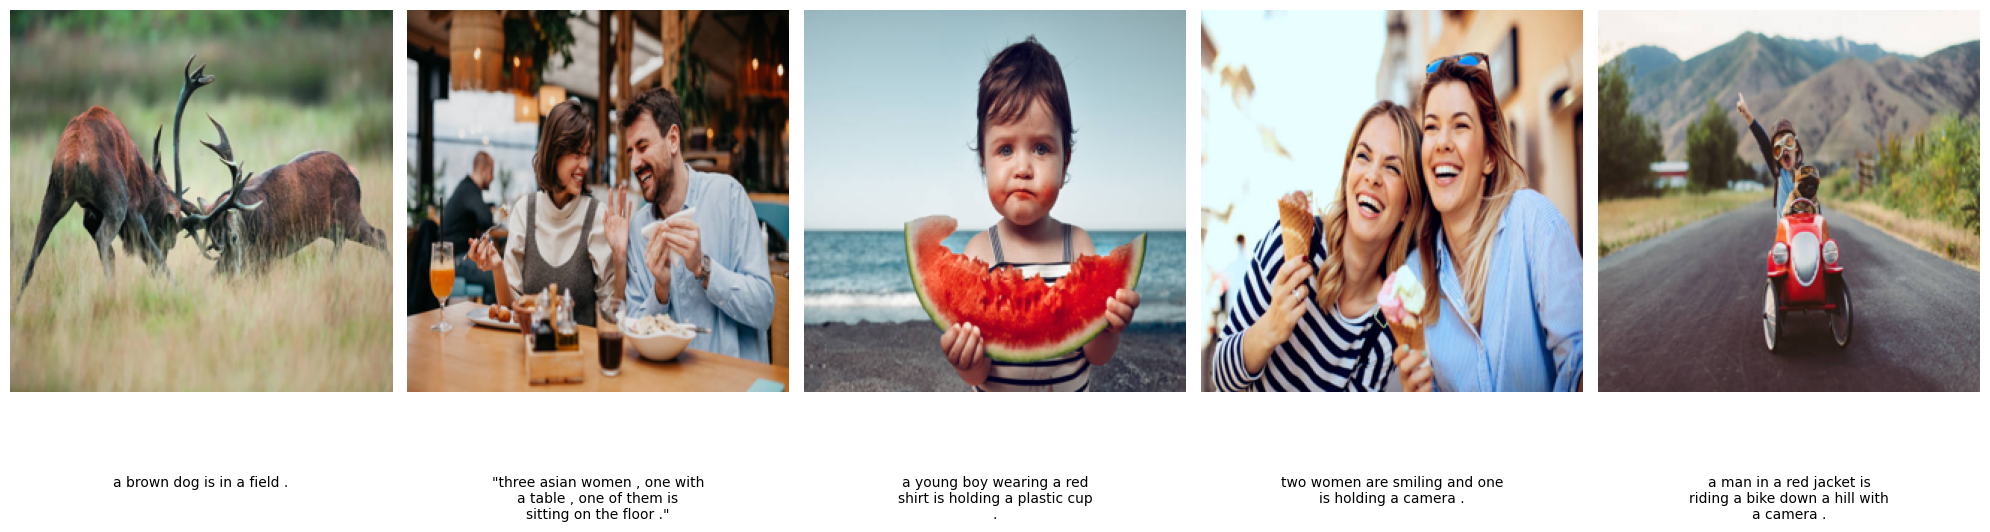

In [6]:
# List of image paths
test_image_dir = '/kaggle/input/images-for-captioning/images for captioning'
test_image_paths = [
    os.path.join(test_image_dir, f)
    for f in os.listdir(test_image_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

plt.figure(figsize=(4 * len(test_image_paths), 6))

device = "cuda" if torch.cuda.is_available() else "cpu"

for i, img_path in enumerate(test_image_paths):
    # Generate caption
    caption = generate_caption(image_path=img_path, model=model)
    caption = textwrap.fill(caption, width=30)

    # Load and resize image for display
    img = Image.open(img_path).convert("RGB")
    img = img.resize((256, 256))

    # Plot
    ax = plt.subplot(1, len(test_image_paths), i + 1)
    
    ax.imshow(img)
    ax.axis("off")
    
    # Caption BELOW image (this is the key)
    ax.text(
        0.5, -0.22, caption, ha="center", va="top",
        wrap=True, fontsize=10, transform=ax.transAxes
    )

plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()